# DS 2500 Day 14

Feb 27, 2023

Content:
- Decision Trees
- Gini Impurity
    - If I make a guess, how often am I wrong?
- Random Forests
    - variable importance
        - which of my features is driving classification?
    - (less overfit too)

Admin:
- project team matching, google form due thursday at 9AM
- research study
    - [see piazza for detail](https://piazza.com/class/lbxsbawi9yq2f9/post/274)
    

## Decision Tree


A **decision tree** is 
- a classifier
- a flowchart (directed binary tree) where each node partitions samples via a single feature

In [1]:
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

df_titanic = sns.load_dataset('titanic')

# we can represent a binary categorical variable in a single indicator tag (males assumed False)
df_titanic['is_female'] = df_titanic['sex'] == 'female'

# discard any rows missing data
df_titanic.dropna(axis=0, inplace=True)

In [2]:
def train_dec_tree_titanic(df_titanic, max_depth=3, x_feat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_titanic (pd.DataFrame): titanic passengers
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_feat_list is None:
        # default x_feat_list
        x_feat_list = ['pclass', 'is_female', 'age', 'sibsp', 'parch', 'fare', 'alone']

    # extract data from dataframe
    x = df_titanic.loc[:, x_feat_list].values
    y = df_titanic.loc[:, 'survived'].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(15, 10)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_feat_list)
    
    return dec_tree_clf

In [3]:
# how many did / didn't survive the titanic in our dataframe?
df_titanic['survived'].value_counts()

1    123
0     59
Name: survived, dtype: int64

In [4]:
df_titanic['is_female'].value_counts()

False    94
True     88
Name: is_female, dtype: int64

# Super Important (and not-so-intuitive) Sci-kit Learn Convention: 
- leftward branches are 'yes'
- rightward branches are 'no'

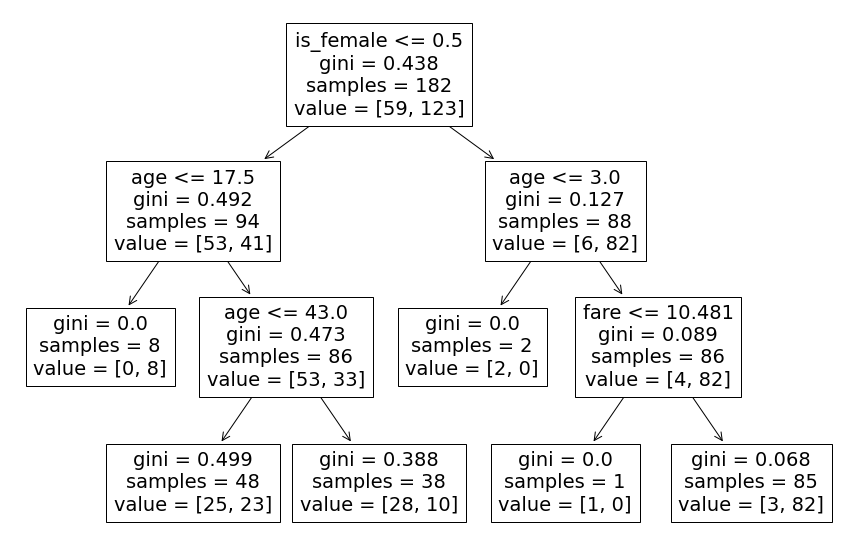

In [5]:
dec_tree = train_dec_tree_titanic(df_titanic, max_depth=3, plot=True)

### Questions

1. How do we learn the order of variables in the tree?
    - ie. why `is_female` as the root note above?
1. How do we learn the threshold at each particular node?
1. We stop at a `max_depth=3` here (for pedagogical reasons), but what depth should be used in general?

## Gini Impurity
Gini Impurity:
If I just guess* whats the probability that I'm going to be incorrect?

*Guessing is done per the distribution.  In the Titanic example
- we guess survive 67.58% of the time
- we guess no survive 32.42% of the time

because:

In [6]:
prob_survive = df_titanic['survived'].value_counts(normalize=True)
prob_survive


1    0.675824
0    0.324176
Name: survived, dtype: float64

From the titanic example above:

<img src="gini_explained0.png" width=1200px>

So that we may compute our Gini Impurity Score (total prob of being incorrect by guessing) for a binary distribution, as:

$$\begin{align}
\texttt{Gini}(p) 
&= p_0 p_1 + p_1 p_0
\end{align}
$$

(there's a more convenient form to compute below ... this one is included to build intuition)

So that the probability of being correct by just guessing ("Gini Impurity"):

In [7]:
# shorter names for consistency with formula above
p0 = prob_survive[0]
p1 = prob_survive[1]

# compute gini impurity of all passengers (initially)
# ... we can see this value in the root node of the decision tree below (or above)
gini = p0 * (1 - p0) + p1 * (1 - p1)
gini

0.4381717183914986

DecisionTreeClassifier(max_depth=1)

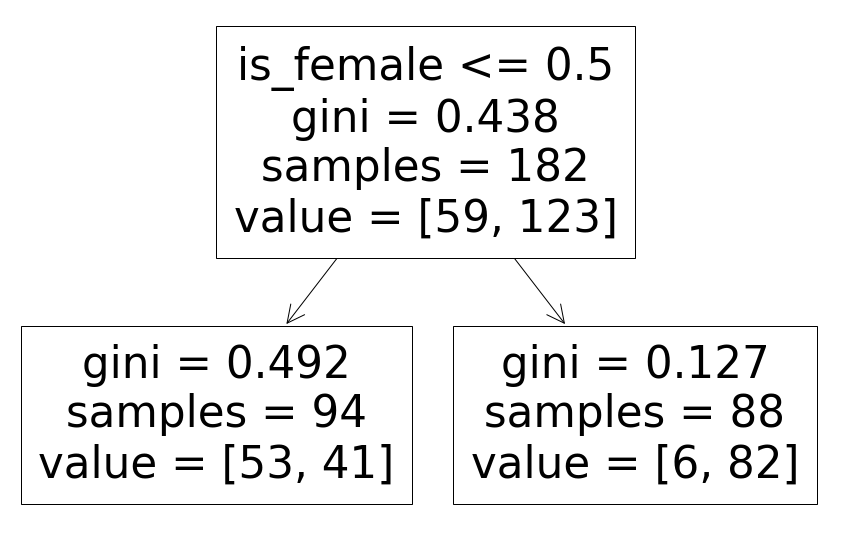

In [8]:
# see the .438 in the top node of tree?
train_dec_tree_titanic(df_titanic, max_depth=1, plot=True)

## Gini Impurity Score: Intuition

Gini Impurity Score: If I just guess, according to the given distribution, whats the probability I'm going to be incorrect?

$$\begin{align}
\texttt{Gini}(p) 
&= p_0 p_1 + p_1 p_0
\end{align}
$$

In [9]:
# an easily classified distribution, all samples are of class 0
prob_class0 = 1
prob_class1 = 0
gini = prob_class0 * prob_class1 + prob_class1 * prob_class0
gini

0

In [10]:
# a tough to classify distribution, samples evenly split between classes
p0 = 1/2
p1 = 1/2
gini = p0 * p1 + p1 * p0
gini

0.5

Intuition:
- high Gini impurity value
    - samples belong to many classes
    - this is not desired
        - ... our classification is not yet done
- low Gini impurity value
    - all samples belong to a single class
    - this is desired
        - ... our classification is closer to being done
        
**As we move down the decision tree, we want Gini to get closer to 0.**

## Training (Building) a Decision Tree

Remember: 
- low Gini score is good:
    - (samples mostly belong to a single class)
    
**A feature & its associated threshold are chosen in a decision tree to minimize the mean Gini Coefficient of the output nodes**

Across all features `['pclass', 'is_female', 'age', 'sibsp', 'parch', 'fare', 'alone']` and every possible threshold of each, the feature & threshold which decreases Gini the most is `is_female` at a threshold of `.5`:

DecisionTreeClassifier(max_depth=1)

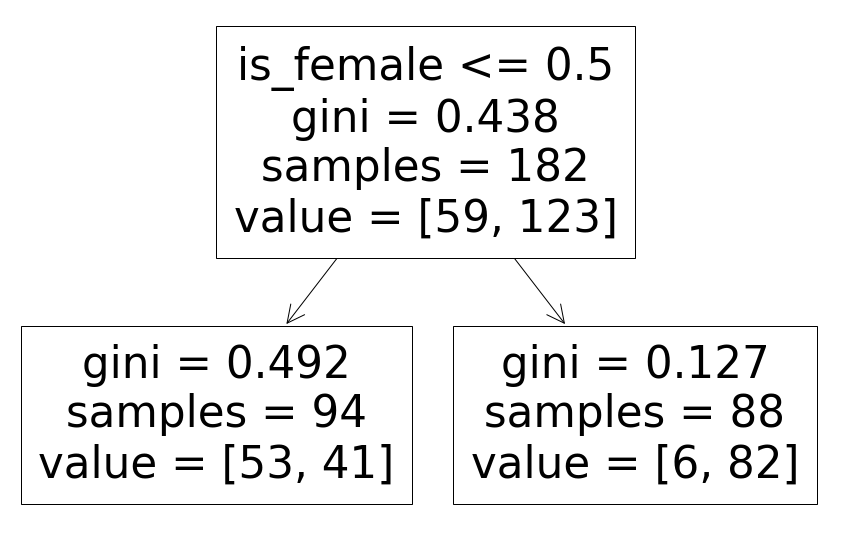

In [11]:
train_dec_tree_titanic(df_titanic, max_depth=1, plot=True)

Notice that Gini score can go up for some samples (observe `.492 > .438` from root to left node) but it is always reduced on average:

In [12]:
# mean gini before is .438 (by observation, no compute)

# compute mean gini after
mean_gini_after = 94 / (88 + 94) * .492 + \
                  88 / (88 + 94) * .127

mean_gini_after

0.31551648351648354

Remember:

A feature & its associated threshold are chosen in a decision tree to minimize **the mean Gini Coefficient** of the output nodes


### Decision Tree Growth:
- Initialize a root which represents all samples
- Split samples of each leaf node until either
    - `max_depth` is reached
    - `gini=0` (all samples belong to a single class)
    
Notice that when `max_depth` is reached, there may be samples from many classes in a given node:
    
**A decision tree estimates as the most common class in a sample's resultant leaf**

### Extending to n-class Gini Coefficient (more effective computation)

Extending our formula to work for 3-classes (instead of just the 2-class case above):

<img src="gini_explained1.png" width=800px>

So that we may compute our 3-class Gini Impurity Score as:

$$\begin{align}
\texttt{Gini}(p) 
&= p_0 p_1 + p_0 p_2 + p_1 p_0 + p_1 p_2 + p_2 p_0 + p_2 p_1
\\
&= p_0 (1 - p_0) + p_1 (1 - p_1) + p_2 (1 - p_2)
\\
&= p_0 - p_0^2 + p_1 - p_1^2 +p_2 - p_2^2 
\\
&= p_0 + p_1 +p_2 -p_0^2 - p_1^2 - p_2^2 
\\
&= 1 -p_0^2 - p_1^2 - p_2^2 
\end{align}
$$

A similar set of equalities could be made for the n-class problem so that
$$ \texttt{Gini}(p) = 1 - \sum_i p_i ^2 $$
where $p_i$ is the probability that a sample belongs to class $i$ among your samples.

The formula above is great to compute Gini scores (though less great to understand them...)

## ICA 1

1. Train and display a decision tree with `max_depth=3` which classifies the `species` of a penguin via the four features shown below in the `sns.pairplot()`
1. Classify the following penguin by manually following their path through the tree:
    - body_mass_g = 4000
    - flipper_length_mm = 200
    - bill_depth_mm = 17
    - bill_length_mm = 45
1. Build a confusion matrix which shows how this decision tree performs in classifying "new" samples (cross validate).
1. Repeat part 1 of this ICA but set `max_depth=None` so that the tree continues building nodes until leaf nodes contain only a single class of samples (i.e. Gini score of each leaf is 0).  Critique this decision tree, is it appropriate to use on some new, unseen sample?
        


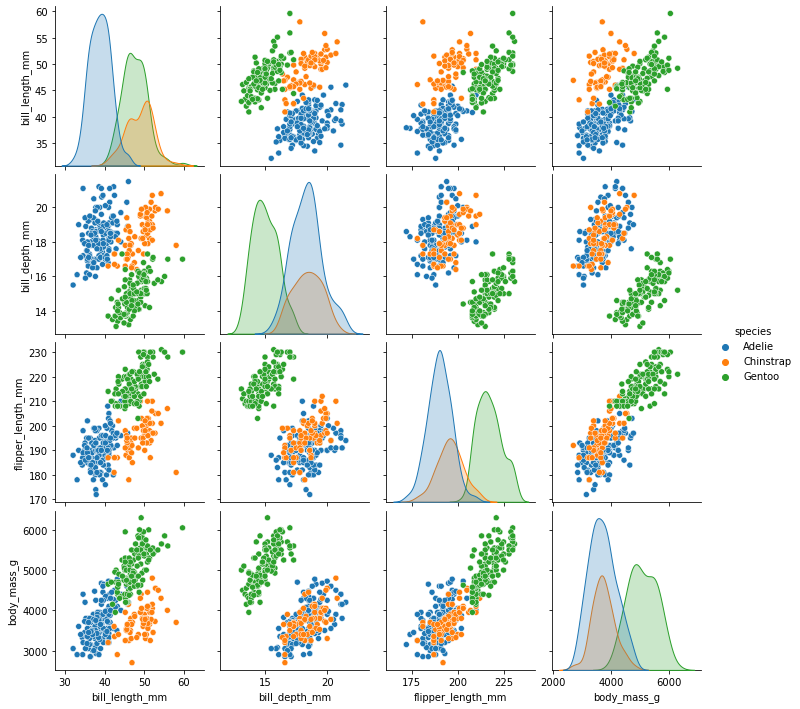

In [13]:
import pandas as pd
import seaborn as sns

df_penguin = sns.load_dataset('penguins')

df_penguin.dropna(axis=0, inplace=True)

sns.pairplot(df_penguin, hue='species')

- body_mass_g = 4000
- flipper_length_mm = 200
- bill_depth_mm = 17
- bill_length_mm = 45

----------------------

- since flipper_length_mm <= 206.5 (yes) we move left
- since bill_length_mm > 43.35     (no)  we move right
- since body_mass_g <= 4125        (yes) we move left

we estimate as the second species (chinstrap):

In [14]:
# train & decision tree
from sklearn import tree
def train_dec_tree_penguin(df_penguin, max_depth=3, x_feat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_penguin (pd.DataFrame): penguins
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_feat_list is None:
        # default x_feat_list
        x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    # extract data from dataframe
    x = df_penguin.loc[:, x_feat_list].values
    y = df_penguin.loc[:, 'species'].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(20, 15)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_feat_list, class_names=dec_tree_clf.classes_);
    
    return dec_tree_clf

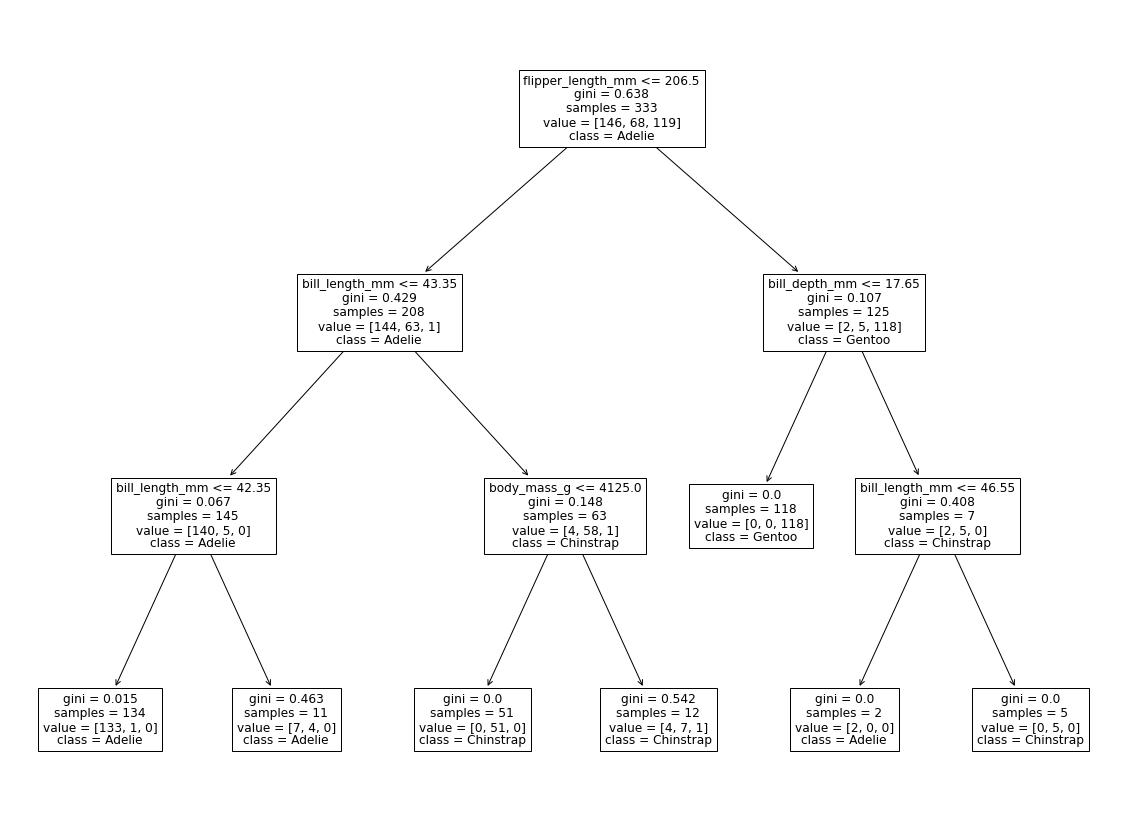

In [15]:
decision_tree = train_dec_tree_penguin(df_penguin, max_depth=3, plot=True)

In [16]:
# Classify the following penguin by manually following their path through the tree:
"""
body_mass_g = 4000
flipper_length_mm = 200
bill_depth_mm = 17
bill_length_mm = 45m
"""
class_of_penguin = 'Chinstrap'

In [17]:
# confusion matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

# initalized kfold
skfold = StratifiedKFold(n_splits=5)

# initalized decision tree
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)

# default x_feat_list
x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# extract data from dataframe
x = df_penguin.loc[:, x_feat_list].values
y = df_penguin.loc[:, 'species'].values

# initalized y_pred
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x,y):
    # training data
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    
    # testing data
    x_test = x[test_idx]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estiamte on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

Text(0.5, 0.98, 'max_depth=3 decision tree')

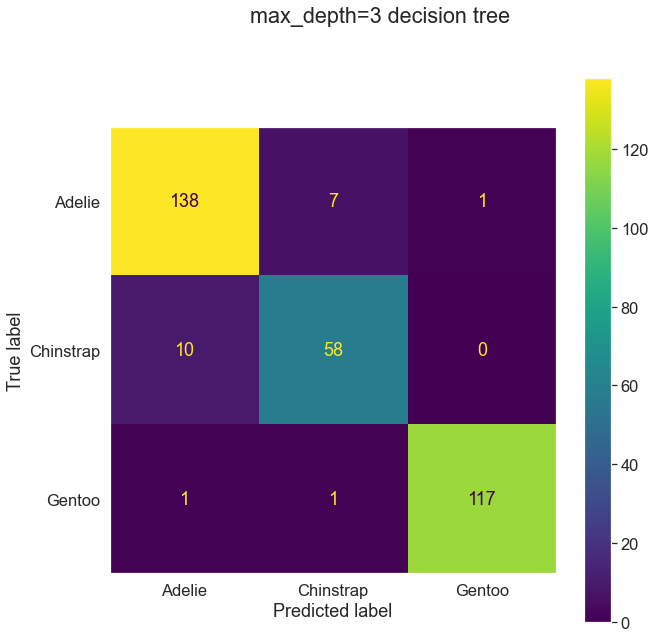

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_display = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.set(font_scale=1.5)
conf_mat_display.plot()
plt.gcf().set_size_inches(10,10)
plt.grid(False)
plt.suptitle('max_depth=3 decision tree')

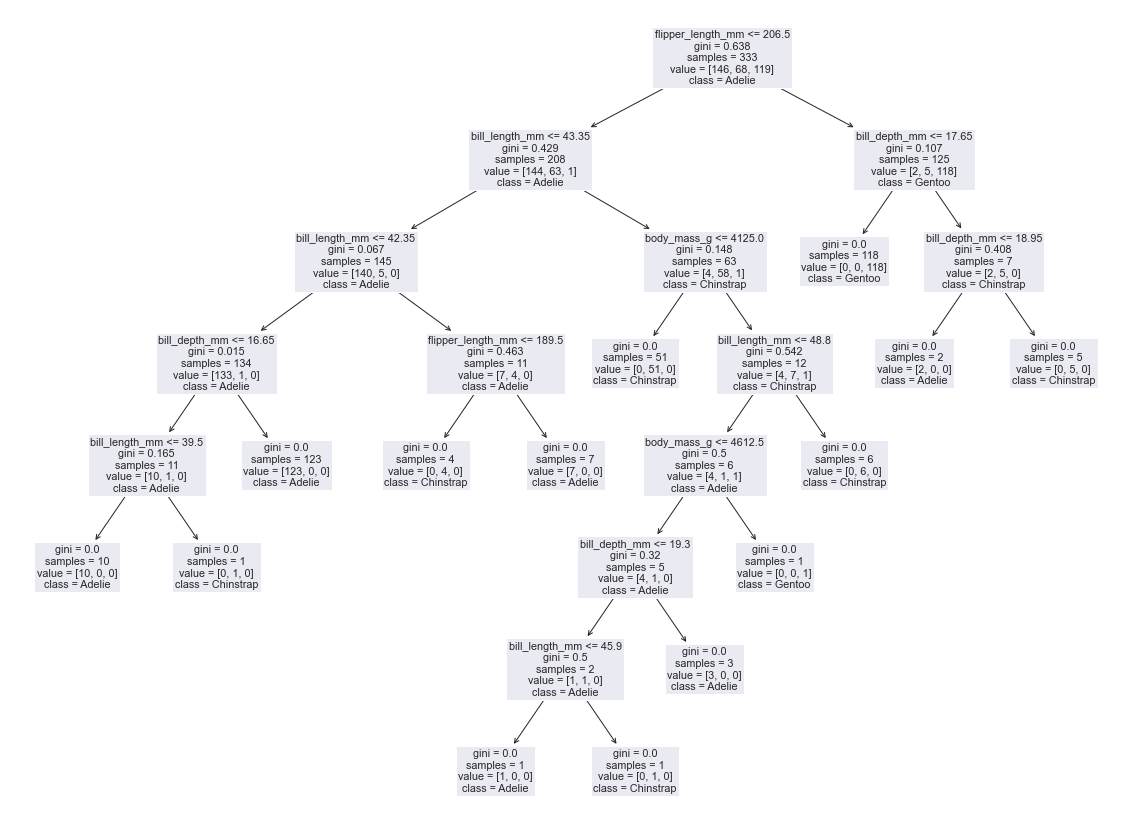

In [19]:
#repeat
from matplotlib.backends.backend_pdf import PdfPages

f_out = 'penguin_dec_tree_overfit.pdf'
n_decision_tree = train_dec_tree_penguin(df_penguin, max_depth=None, plot=True)

with PdfPages(f_out) as pdf:
    pdf.savefig(plt.gcf())

# Overfitting

Can we really trust this threshold at the bottom of our tree?

<img src="https://i.ibb.co/8znxdGL/overfit-detail.png" width=400>

Sure it works for these two penguins in the training set ... but are two penguins enough to inform a threshold which is applicable to new penguins which aren't in the training set?

(We're just touching on "overfitting" today, we'll dive into it when we cover regression)

## From Decision Trees to Random Forests ... why?

## 1. Less overfitting

## 2. Variable Importance
- we want to quantify how important each of the features is to succesful classification
- which feature describe why ...
| **classification question? (target feat bold)** | **features used**                                                          | **stolen from team idx** |
|-------------------------------------------------|----------------------------------------------------------------------------|--------------------------|
| is worker **happy/sad** in the workplace?       | salary, hrs/wk, benefits, age                                              | 1                        |
| is a flight is **on time**?                     | weather, capacity, city_to, city_from                                      | 2                        |
| is a book is **in the romance category**        | length of book, price of book, demographics of purchasers                  | 6                        |
| is tiktok video popular (**likes**)             | length of video, frequency of posts, author metadata                       | 7                        |
| **how much will ocean temp rise**?              | economics data about neighboring country, season, co2 emissions (globally) | 8                        |
| what **test score** will student get?           | demographics of student, school data (teacher, class size), zip code       | 9                        |

## Random Forest: Method

### Approach
1. Build a bunch of different decision trees
    - each uses a different set of training data (see Bagging below)
        - if they each used full dataset they'd all be the same ...
    - each node is restricted to use only some subset of features
        - for $n$ features, typically $\sqrt{n}$ of features are available to a given node
1. estimate as the majority classification among all the trees

(Descriptive names: Decision Tree & Random Forest, right?  Sure beats Type I / Type II error ...)

### How does a Random Forest build different sets of training data?
**B**ootstrap **Agg**regation (**Bagg**ing)
- build a training set by resampling from a set of samples with replacement
    - this training set is called a "bag" of samples 
        - bags may have repeated samples
    - by convention, we don't call this training set a "fold" 
        - folds may not have repeated samples

In [20]:
import pandas as pd

# nonsense data
df = pd.DataFrame({'feat0': [1, 24, 8, 287], 
                  'feat1': [4, 6, 23, 985]},
             index=['sample_a', 'sample_b', 'sample_c', 'sample_d'])
df

,feat0,feat1
sample_a,1,4
sample_b,24,6
sample_c,8,23
sample_d,287,985


In [21]:
# bootstrap sample 4 samples from df
# notice: some samples may appear more than once in new training dataset
df.sample(4, replace=True)

,feat0,feat1
sample_d,287,985
sample_c,8,23
sample_b,24,6
sample_b,24,6


## Random Forest Motivation: Measuring Feature Importance

According to the scikit-learn documentation: 
 >The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
 
In other words, a features importance is a ratio of:

    feat_import = total gini reduced (across all nodes of all trees in forest) due to one feature
                  --------------------------------------------------------------------------------------
                  total gini reduced (across all nodes of all trees in forest) due to all features

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load titanic data
df_titanic = sns.load_dataset('titanic')
df_titanic.dropna(axis=0, inplace=True)

# we can represent a binary categorical variable in a single indicator tag (males assumed False)
df_titanic['is_female'] = df_titanic['sex'] == 'female'

x_feat_list = ['pclass', 'is_female', 'age', 'sibsp', 'parch', 'fare', 'alone']

# extract data from dataframe
x = df_titanic.loc[:, x_feat_list].values
y = df_titanic.loc[:, 'survived'].values

rf_clf = RandomForestClassifier(n_estimators=100)

rf_clf.fit(x, y)

RandomForestClassifier()

In [23]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

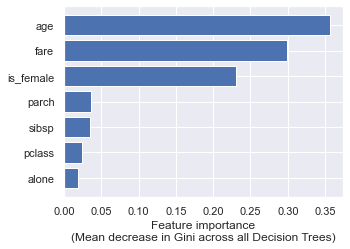

In [24]:
import numpy as np
import seaborn as sns

sns.set()

plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit=10)

Note that no direction is implied by a feature's importance:

Age being high on this doesn't imply either old or young people having better chances at survival.  (Could be that there are some age ranges which do better at survival ... decision trees can re-use a feature in multiple nodes!)

## Nobody cares which features are important in a classifier that doesn't work ...
Before showing a plot / analysis like this, provide a confusion matrix which demonstrates that the classifier works.

## Why not just compute Gini reduction on a single decision tree?
Given a single decision tree, we can quantify a feature's importance as the reduction in Gini produced across all the nodes which utilize this feature.  That should work, right?

What if two features are correlated?  A feature's importance can be "split" between some other correlated features.
- Example: What does it take to succeed in professional basketball?
    - height
    - weight
    - shoe size
    - hand span
    - hours spent playing basketball as a child
    
Random Forests, a variety of different trees can provide insight into how each feature helps classification performance by itself.

This motivates why each tree in a Random Forest must have limited access to:
- samples
    - some samples may be withheld from each tree's training by sampling
- features
    - we restrict a random forest to choose from a random subset of features in each node

## In Class Assignment 2

1. Build a Random Forest Classifier which classifies whether a breast image contains a malignant (growing) or benign (static) tumor.
1. Print a confusion matrix which estimates how well the classifier performs on new breast images.  Qualitatively describe if your classifier is a useful clinical tool to a non-technical expert.
    - If we're estimating performance on new samples we must cross validate
1. Print a bar plot (`plot_feat_import()`) to describe which features are most useful for classification.  Qualitatively describe if these most important features are clinically meaningful.  In other words:
    - If the classifier performs well, we care about which features helped it work
    - If the classifier doesn't perform well, we don't care which features helped it "work"

In [25]:
from sklearn.datasets import load_breast_cancer

bcancer_dict = load_breast_cancer()

print(bcancer_dict['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [26]:
# loading data from sklearn is convenient because its already an array!
x = bcancer_dict['data']
y = bcancer_dict['target']

x_feat_list = bcancer_dict['feature_names']
y_feat_list = bcancer_dict['target_names']
x_feat_list

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [27]:
y_feat_list

array(['malignant', 'benign'], dtype='<U9')

In [28]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
import numpy as np

Text(0.5, 0.98, 'Important features')

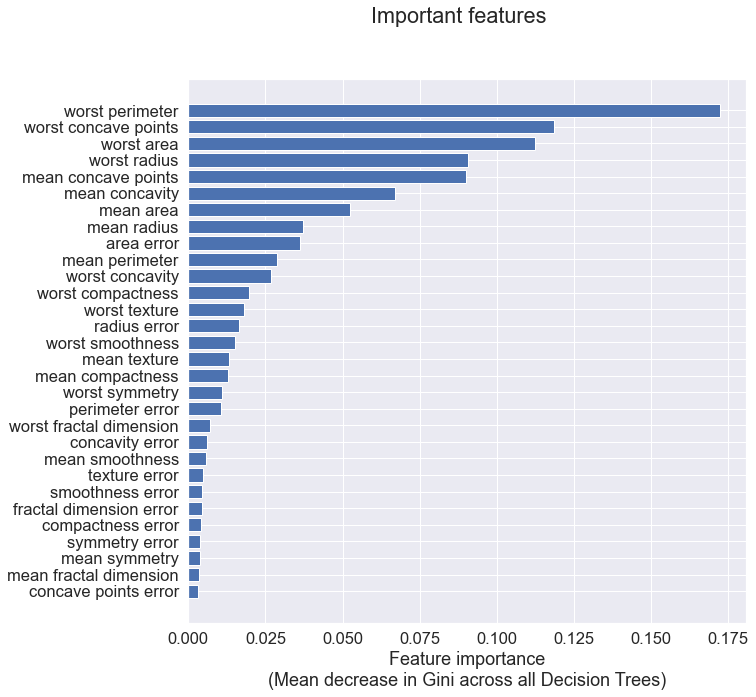

In [29]:
# random forest classifer
sns.set(font_scale=1.5)

# number of decision trees in the forest
n_estimators = 100
rf_clf = RandomForestClassifier(n_estimators=n_estimators)

# fit random forest
rf_clf.fit(x,y)

# print bar plot
plot_feat_import(x_feat_list, rf_clf.feature_importances_)
plt.gcf().set_size_inches(10,10)
plt.suptitle('Important features')


Text(0.5, 0.98, 'max_depth=3 decision tree')

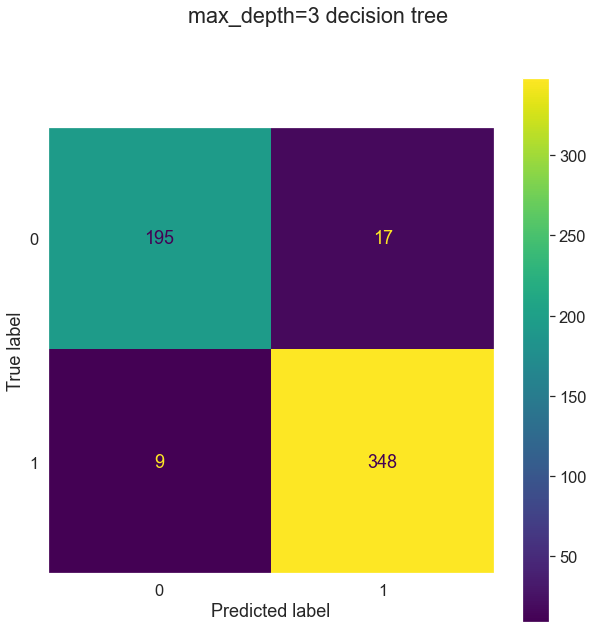

In [30]:
# confusion matrix
# initalized kfold
skfold = StratifiedKFold(n_splits=10)

# initalized random decision tree
dec_tree_clf = RandomForestClassifier(max_depth=3)

# initalized y_pred
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x,y):
    # training data
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    
    # testing data
    x_test = x[test_idx]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estiamte on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

# build & plot
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_display = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.set(font_scale=1.5)
conf_mat_display.plot()
plt.gcf().set_size_inches(10,10)
plt.grid(False)
plt.suptitle('max_depth=3 decision tree')

The above matrix is a useful classifer tool because out of 205, 196 predicted 0 are true and 348/364 predicted 1 are true. There is a 95% accuracy rate (roughly), which is really high accuracy rate.

The most important features that are clinically meaningful. Mean concave point (0.17), Worst perimeter (0.13), and worst concave point (03) are the top three most important features. These features are very impactful because they affected the examination for malignant or beigned tumor. 